In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn. linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

In [2]:
df = pd.read_csv('train.csv', index_col=0)
df.sort_index(inplace= True)

In [3]:
df

,RevolvingUtilizationOfUnsecuredLines,Age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
ID,,,,,,,,,,,
1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
2,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0
3,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0
4,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0
5,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
149993,0.871976,50,0,4132.000000,NaN,11,0,1,0,3.0,0
149994,1.000000,22,0,0.000000,820.0,1,0,0,0,0.0,0
149996,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105000 entries, 1 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  105000 non-null  float64
 1   Age                                   105000 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  105000 non-null  int64  
 3   DebtRatio                             105000 non-null  float64
 4   MonthlyIncome                         84164 non-null   float64
 5   NumberOfOpenCreditLinesAndLoans       105000 non-null  int64  
 6   NumberOfTimes90DaysLate               105000 non-null  int64  
 7   NumberRealEstateLoansOrLines          105000 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  105000 non-null  int64  
 9   NumberOfDependents                    102236 non-null  float64
 10  SeriousDlqin2yrs                      105000 non-null  int64  
dtypes: fl

Imputamos la media al Monthly income y la moda (ya que son os y 1s, a Number of Dependents)

In [5]:
df.fillna({'MonthlyIncome' : df['MonthlyIncome'].median()}, inplace= True)
df.fillna({'NumberOfDependents': df['NumberOfDependents'].mode()[0]}, inplace= True)

In [6]:
print(df['DebtRatio'].unique().max())
print(df['DebtRatio'].unique().min())
print(df['DebtRatio'].unique().std())
print(df['DebtRatio'].unique().mean())
print(np.percentile(df, 75))
print(np.percentile(df, 90))
print(np.percentile(df, 85))
df['DebtRatio'].quantile(0.85)

329664.0
0.0
1944.9547724607423
218.2340170529338
7.0
800.0
52.0


np.float64(281.0)

<Axes: xlabel='DebtRatio'>

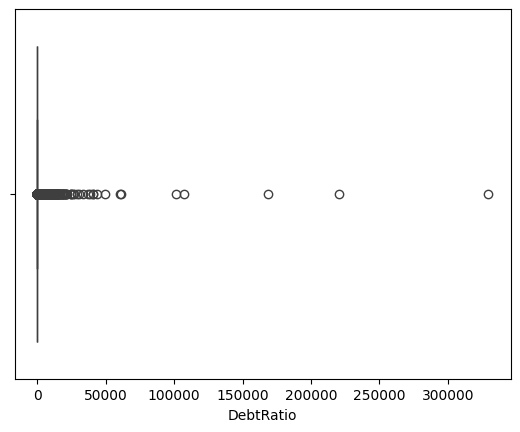

In [7]:
sns.boxplot(x=df['DebtRatio'])

Vemos que hay muchos outliers en Debt Ratio. Como 6 o 7 valores pasan de 50.000, valor máximo del resto, y llegan hasta casi 350.000. Eliminaremos estas filas para que el modelo pueda entrenar correctamente. Igualmente, un Random Forest será una buena opción.

In [8]:
# df = df[df['DebtRatio'] <= 50000]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105000 entries, 1 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  105000 non-null  float64
 1   Age                                   105000 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  105000 non-null  int64  
 3   DebtRatio                             105000 non-null  float64
 4   MonthlyIncome                         105000 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       105000 non-null  int64  
 6   NumberOfTimes90DaysLate               105000 non-null  int64  
 7   NumberRealEstateLoansOrLines          105000 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  105000 non-null  int64  
 9   NumberOfDependents                    105000 non-null  float64
 10  SeriousDlqin2yrs                      105000 non-null  int64  
dtypes: fl

<Axes: >

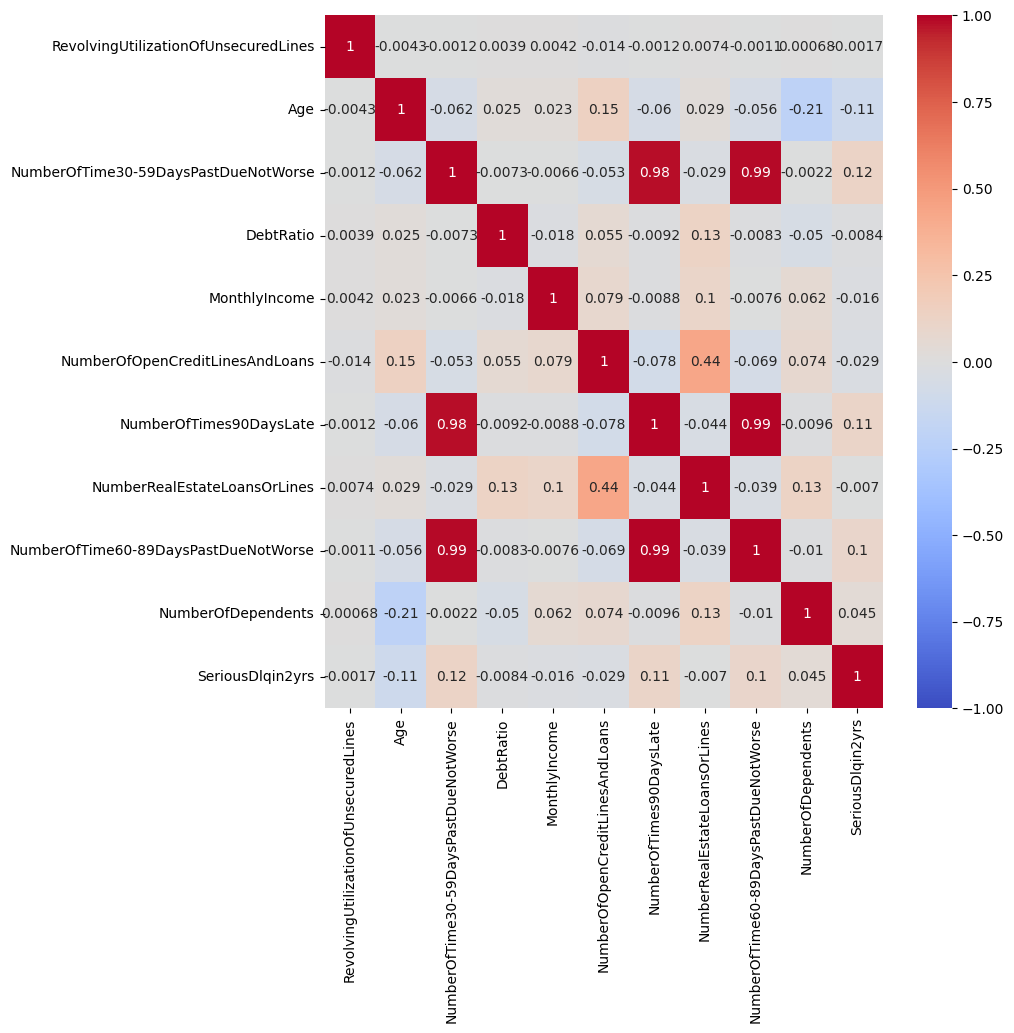

In [10]:
plt.figure(figsize=(9,9))
sns.heatmap(df.corr(numeric_only= True), annot= True, vmax = 1, vmin= -1, cmap="coolwarm")

Hay colinealidad, vamos a quedarnos con las mejores correlaciones evitando la colinealidad. Serían: 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime30-59DaysPastDueNotWorse'

In [11]:
x = df.drop(columns = 'SeriousDlqin2yrs')
y = df['SeriousDlqin2yrs']

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.2, random_state= 10)

In [218]:
print(x.shape)
print(y.shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(104993, 10)
(104993,)
(83994, 10)
(20999, 10)
(83994,)
(20999,)


In [13]:
n_negative = len(y_train[y_train == 0])
n_positive = len(y_train[y_train == 1])

scale_pos_weight = n_negative / n_positive
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 13.962593516209477


La variable está muy desbalanceada

In [14]:
from sklearn.pipeline import make_pipeline

In [24]:
pipeline = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=42))
params = {
    'decisiontreeregressor__max_depth': [3,5],
    'decisiontreeregressor__min_samples_split': [2, 3],
    'decisiontreeregressor__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(pipeline, params, cv=5, scoring="roc_auc", n_jobs=-1)  # scoring= "accuracy" sale algo peor el resultado
grid_search.fit(x, y)


print("Best parameters:", grid_search.best_params_)
print("AUC:", grid_search.best_score_)

c:\Users\Hugo Trabajo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters: {'decisiontreeregressor__max_depth': 3, 'decisiontreeregressor__min_samples_leaf': 1, 'decisiontreeregressor__min_samples_split': 2}
AUC: nan


In [25]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
y_pred_proba = grid_search.best_estimator_.predict_proba(x_test)[:, 1]

AttributeError: This 'Pipeline' has no attribute 'predict_proba'

PIPELINE

In [307]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=14))
])

param_grid = [
    {
        'classifier': [RandomForestClassifier(random_state=10)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [5, 10],
        'classifier__min_samples_split': [2, 5]
    },
]
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    n_jobs=-1
)
grid_search.fit(x, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      import...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid=[{'classifier': [RandomForestClassifier(random_state=10)],
                          'classifier__max_depth': [5, 10],
                          'classifier__min_samples_split': [2, 5],
                          'classifier__n_estimators': [100, 200]}],
             scoring='roc_auc', verbose=2)

In [308]:
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.8621785214386746
{'classifier': RandomForestClassifier(random_state=10), 'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=5,
                                        n_estimators=200, random_state=10))])


In [291]:
y_pred = grid_search.best_estimator_.predict(x_test)
y_pred_proba = grid_search.best_estimator_.predict_proba(x_test)[:, 1]

Accuracy: 0.946473641601981
Confusion Matrix:
 [[19539    57]
 [ 1067   336]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     19596
           1       0.85      0.24      0.37      1403

    accuracy                           0.95     20999
   macro avg       0.90      0.62      0.67     20999
weighted avg       0.94      0.95      0.93     20999

AUC: 0.8929907655670926


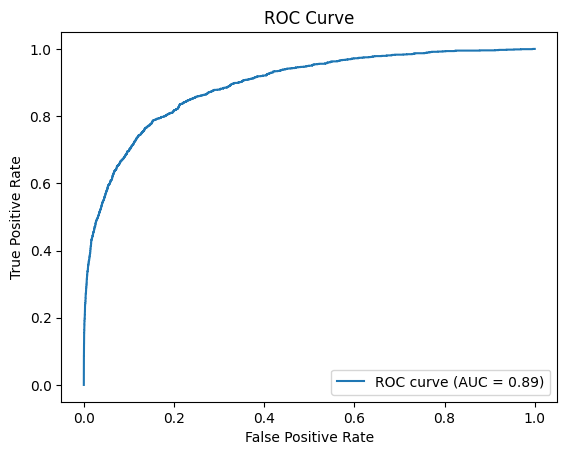

In [292]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_pred_proba)
print("AUC:", auc)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [26]:
pruebacsv = pd.read_csv('test.csv', index_col=0)
pruebacsv.sort_index(inplace= True)

In [32]:
pruebacsv_pred =best_model.predict(pruebacsv)
pruebacsv_pred

array([0.02117872, 0.02117872, 0.10435246, ..., 0.02117872, 0.02117872,
       0.10435246])

In [33]:
df_final = pd.read_csv('sample_submission.csv', index_col = 0)

In [34]:
df_final.sort_index(inplace= True)

In [35]:
df_final['SeriousDlqin2yrs'] = pruebacsv_pred

In [36]:
df_final.reset_index(inplace=True)

In [37]:
df_final.head()

,ID,SeriousDlqin2yrs
0,6,0.021179
1,7,0.021179
2,8,0.104352
3,15,0.021179
4,19,0.021179


In [38]:
df_final.to_csv('Hugo-kaggle-pasta-6.csv', index = False)